# Stadium Billiard Assignment — Analytic Simulation

This notebook implements a clean, analytic stadium billiard simulator as required for the assignment below.

---

## **Assignment Question (from Tassignment1.pdf)**

### **Stadium Billiard**

A stadium billiard consists of a rectangle of width $2a$ and height $2b$, capped at each end by a half-ellipse of semi-axes $r_x$ (horizontal) and $r_y$ (vertical). A point particle moves freely inside the stadium, bouncing elastically off the boundary.

---

### **(a) Write down the equations for the boundary of the stadium, and describe the conditions for a collision with each part of the boundary.**

---

### **Stadium Boundary Equations**

The boundary of the stadium consists of:

1. **Rectangle (centered at origin):**

    $$ |x| \leq a, \quad |y| \leq b $$

2. **Left ellipse cap (centered at $x = -a$):**

    $$ \frac{(x + a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

3. **Right ellipse cap (centered at $x = +a$):**

    $$ \frac{(x - a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

---

### **Collision Conditions**

- **Horizontal walls:**  
  Collision occurs when $y = +b$ or $y = -b$ and $|x| \leq a$.

- **Ellipse caps:**  
  Collision occurs when the particle reaches the ellipse boundary at $x = \pm a$ and satisfies:  
  $$ \frac{(x \mp a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

- **Note:**  
  Only collisions with horizontal walls and ellipse caps are considered; there are no vertical-wall reflections at $x = \pm a$.
  

In [41]:
!pip install numpy pandas matplotlib seaborn scikit-learn jupyterlab

Defaulting to user installation because normal site-packages is not writeable


In [42]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import isfinite

# Stadium parameters
# Rectangle: |x| <= a, |y| <= b
# Ellipse caps: centered at x=±a, semi-axes rx, ry

a = 3.0   # half-width of rectangle
b = 1.0   # half-height of rectangle
rx = 2.0  # ellipse semi-axis in x (caps)
ry = b    # ellipse semi-axis in y
EPS = 1e-9


In [43]:
def ellipse_quadratic_coeffs(x0, y0, vx, vy, cx):
    # ellipse centered at (cx,0): ((x-cx)/rx)^2 + (y/ry)^2 = 1
    dx0 = x0 - cx
    A = (vx*vx)/(rx*rx) + (vy*vy)/(ry*ry)
    B = 2*(dx0*vx)/(rx*rx) + 2*(y0*vy)/(ry*ry)
    C = (dx0*dx0)/(rx*rx) + (y0*y0)/(ry*ry) - 1.0
    return A, B, C

def solve_quadratic(A, B, C):
    # robust quadratic solver for real roots; returns sorted positive roots list
    if abs(A) < 1e-18:
        if abs(B) < 1e-18:
            return []
        t = -C / B
        return [t] if isfinite(t) else []
    disc = B*B - 4*A*C
    if disc < 0:
        return []
    sqrt_d = np.sqrt(disc)
    t1 = (-B - sqrt_d) / (2*A)
    t2 = (-B + sqrt_d) / (2*A)
    roots = []
    for t in (t1, t2):
        if isfinite(t):
            roots.append(t)
    roots = sorted(set(roots))
    return roots

def ellipse_normal_at(x, y, cx):
    # gradient of F = (x-cx)^2/rx^2 + y^2/ry^2 - 1 gives normal ~ ((x-cx)/rx^2, y/ry^2)
    nx = (x - cx)/(rx*rx)
    ny = y/(ry*ry)
    v = np.array([nx, ny])
    norm = np.linalg.norm(v)
    if norm == 0:
        return np.array([1.0, 0.0])
    return v / norm

def reflect(v, n):
    # reflect velocity vector v about (unit) normal n
    return v - 2*np.dot(v, n)*n
def kinetic_energy(vx, vy, mass=1.0):
    """Return kinetic energy for given velocity components and mass (default 1)."""
    return 0.5 * mass * (vx**2 + vy**2)


In [ ]:
import pandas as pd

def simulate_trajectory(x0, y0, vx0, vy0, dt=0.01, steps=10000, max_bounces=None, eps_nudge=1e-9):
    x, y = float(x0), float(y0)
    vx, vy = float(vx0), float(vy0)
    X = [x]
    Y = [y]
    bounces = []
    energy_records = []
    bounce_count = 0
    q = 0
    for step in range(steps):
        remaining = dt
        while remaining > 1e-16:
            candidates = []
            if abs(vy) > 1e-16:
                for wall_y in (b, -b):
                    t = (wall_y - y)/vy
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        if abs(x_at) <= a + 1e-12:
                            ny = 1.0 if wall_y > 0 else -1.0
                            if np.dot(np.array([vx, vy]), np.array([0.0, ny])) > 1e-12:
                                candidates.append((t, 1, 'hwall', wall_y, None))
            for sx in (1.0, -1.0):
                cx = sx * a
                A, B, C = ellipse_quadratic_coeffs(x, y, vx, vy, cx)
                roots = solve_quadratic(A, B, C)
                for t in roots:
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        y_at = y + vy*t
                        if sx > 0 and x_at >= a - 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
                        if sx < 0 and x_at <= -a + 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
            if not candidates:
                x += vx * remaining
                y += vy * remaining
                remaining = 0.0
                break
            candidates.sort(key=lambda c: (c[0], c[1]))
            t_coll, _, kind, param, extra = candidates[0]
            x = x + vx * t_coll
            y = y + vy * t_coll
            if kind == 'hwall':
                ny = 1.0 if param > 0 else -1.0
                n = np.array([0.0, ny])
                v_ref = reflect(np.array([vx, vy]), n)
            else:
                cx = param
                n = ellipse_normal_at(x, y, cx)
                v_ref = reflect(np.array([vx, vy]), n)
            bounce_count += 1
            bounces.append((len(X), x, y, kind))
            v_ref = np.array(v_ref, dtype=float)
            speed = np.hypot(v_ref[0], v_ref[1])
            if speed > 0:
                v_ref = v_ref * (np.hypot(vx, vy) / speed)
            vx, vy = float(v_ref[0]), float(v_ref[1])
            vnorm = np.hypot(vx, vy)
            if vnorm > 0:
                x += (vx / vnorm) * eps_nudge
                y += (vy / vnorm) * eps_nudge
            remaining -= t_coll
            # Record energy every 10 bounces
            if bounce_count % 10 == 0:
                energy = kinetic_energy(vx, vy)
                energy_records.append({'bounce': bounce_count, 'energy': energy})
            if max_bounces is not None and bounce_count >= max_bounces:
                remaining = 0.0
                break
        if bounce_count != 0 and (bounce_count) % 10 == 0 and q == 0:
            print(f'step {step}, bounces {bounce_count}, pos=({x:.3f},{y:.3f}), vel=({vx:.3f},{vy:.3f})')
            q = 1 
        elif (bounce_count) % 10 != 0 and q == 1:
            q = 0  
        X.append(x)
        Y.append(y)
    # Record energy at last bounce if not already recorded
    if len(bounces) > 0 and (len(energy_records) == 0 or energy_records[-1]['bounce'] != bounce_count):
        energy = kinetic_energy(vx, vy)
        energy_records.append({'bounce': bounce_count, 'energy': energy})
    return np.array(X), np.array(Y), vx, vy, bounces, energy_records


step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)
   bounce  energy
0      10     1.0
1      20     1.0
2      21     1.0


In [ ]:
# Implementation and meaning of variables in the simulation:

# dt: The fixed time step for each simulation loop iteration.
# dt = 0.01  # Example value, already used in simulate_trajectory

# steps: The total number of simulation steps to run.
# steps = 4000000  # Example value, already used in simulate_trajectory

# remaining: The remaining time in the current dt interval after a collision is processed.
# It is initialized to dt at the start of each step and reduced by t_coll after each collision.

# t: A candidate time to collision with a boundary (wall or ellipse), computed for each possible collision.
# For example, t = (wall_y - y) / vy for horizontal wall collision.

# t_coll: The actual time to the next collision within the current dt interval, chosen as the minimum positive t among candidates.

# Example usage in the simulation loop:
# for step in range(steps):
#     remaining = dt
#     while remaining > 1e-16:
#         # Compute all possible collision times t
#         # Select the minimum t_coll
#         # Update position by t_coll
#         # Update velocity by reflection
#         remaining -= t_coll

step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)
bounces recorded = 21
final velocity: 1.0561713155005683 -0.9404797458285841 speed: 1.4142135623730947


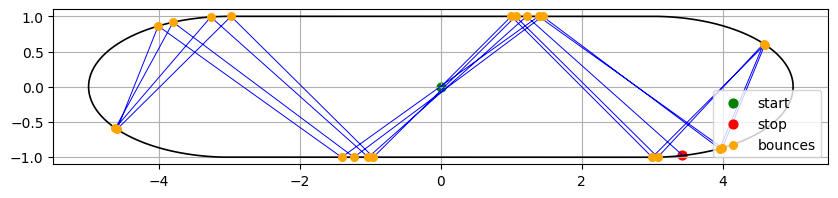

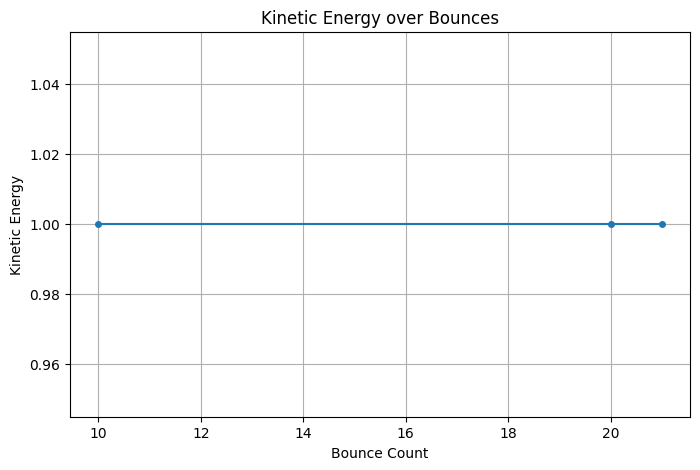

In [47]:
# Run and plot clean stadium billiard trajectory
X, Y, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=4000, eps_nudge=1e-8)
print('bounces recorded =', len(bounces))
print('final velocity:', vx_final, vy_final, 'speed:', np.hypot(vx_final, vy_final))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X, Y, '-b', lw=0.7)
ax.scatter([X[0]], [Y[0]], c='green', s=40, label='start')
ax.scatter([X[-1]], [Y[-1]], c='red', s=40, label='stop')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
# Overlay bounces
if len(bounces) > 0:
    bx = [p[1] for p in bounces]
    by = [p[2] for p in bounces]
    ax.scatter(bx, by, c='orange', s=30, zorder=20, label='bounces')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.savefig('stadium_billiard_clean.png', dpi=120)
plt.show()
#plot energy over bounces
if energy_records:
    energy_table = pd.DataFrame(energy_records)
    plt.figure(figsize=(8,5))
    plt.plot(energy_table['bounce'], energy_table['energy'], '-o', markersize=4)
    plt.xlabel('Bounce Count')
    plt.ylabel('Kinetic Energy')
    plt.title('Kinetic Energy over Bounces')
    plt.grid(True)
    plt.savefig('kinetic_energy_over_bounces.png', dpi=120)
    plt.show()



In [ ]:
print("Pending test case implementation above")

Pending test case implementation above


step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)
step 5412, bounces 30, pos=(-1.132,-0.995), vel=(1.111,0.875)
step 7244, bounces 40, pos=(-1.275,-0.992), vel=(1.145,0.830)
step 9073, bounces 50, pos=(-1.462,-0.998), vel=(1.128,0.853)
step 10923, bounces 60, pos=(-1.285,-0.992), vel=(1.073,0.921)
step 12774, bounces 70, pos=(-1.074,-0.992), vel=(1.006,0.994)
step 14618, bounces 80, pos=(-0.992,-0.993), vel=(1.015,0.984)
step 16456, bounces 90, pos=(-1.031,-0.992), vel=(1.053,0.944)
step 18291, bounces 100, pos=(-1.121,-0.994), vel=(1.103,0.886)
step 20123, bounces 110, pos=(-1.262,-0.995), vel=(1.134,0.845)
step 21959, bounces 120, pos=(-1.333,-0.993), vel=(1.150,0.823)
step 23789, bounces 130, pos=(-1.502,-1.000), vel=(1.104,0.884)
step 25651, bounces 140, pos=(-1.095,-0.996), vel=(0.977,1.023)
step 27392, bounces 150, pos=(-2.856,-0.990), vel=(0.941,1.056)
step 29131, bounces 160, pos=(-3.588,-0.955), vel=(-0.

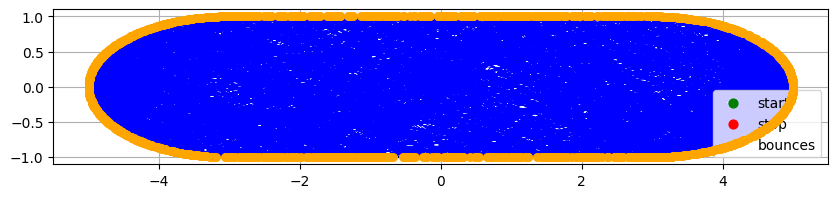

Energy conserved!
     bounce  energy
0        10     1.0
1        20     1.0
2        30     1.0
3        40     1.0
4        50     1.0
..      ...     ...
175    1760     1.0
176    1770     1.0
177    1780     1.0
178    1790     1.0
179    1800     1.0

[180 rows x 2 columns]


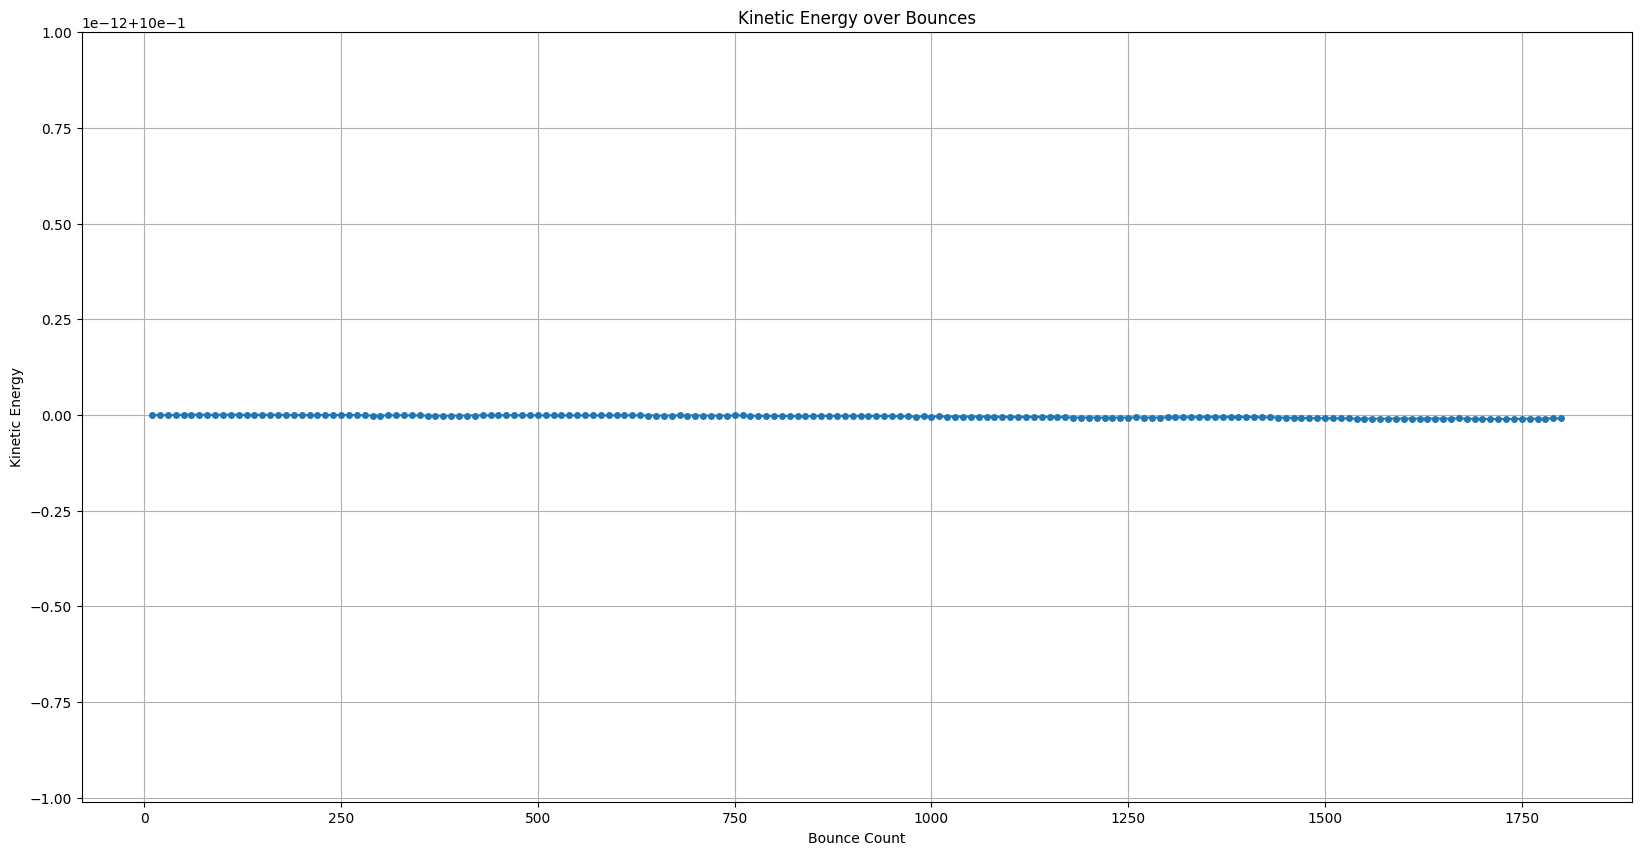

In [70]:
# Run and plot clean stadium billiard trajectory
X, Y, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=400000, eps_nudge=1e-8)
print('bounces recorded =', len(bounces))
print('final velocity:', vx_final, vy_final, 'speed:', np.hypot(vx_final, vy_final))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X, Y, '-b', lw=0.7)
ax.scatter([X[0]], [Y[0]], c='green', s=40, label='start')
ax.scatter([X[-1]], [Y[-1]], c='red', s=40, label='stop')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
# Overlay bounces
if len(bounces) > 0:
    bx = [p[1] for p in bounces]
    by = [p[2] for p in bounces]
    ax.scatter(bx, by, c='orange', s=30, zorder=20, label='bounces')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.savefig('stadium_billiard_clean.png', dpi=120)
plt.show()
#plot energy over bounces
#convert to integer energy records

if energy_records:
    energy_table = pd.DataFrame(energy_records)
    if np.allclose(energy_table['energy'], 1.0, atol=1e-8):
        print("Energy conserved!")
    else:
        print("Energy not conserved!")

    plt.figure(figsize=(20,10))
    plt.plot(energy_table['bounce'], energy_table['energy'], '-o', markersize=4)
    print(energy_table)
    plt.xlabel('Bounce Count')
    plt.ylabel('Kinetic Energy')
    plt.title('Kinetic Energy over Bounces')
    plt.grid(True)
    plt.savefig('kinetic_energy_over_bounces.png', dpi=120)
    plt.show()


In [ ]:
## Discussion: Ergodicity and Generic Initial Conditions in Stadium Billiards

In the stadium billiard, the geometry combines straight segments (rectangle) and curved caps (half-ellipses), which is known to produce chaotic dynamics. When a particle is launched with **generic initial conditions**—meaning its starting position and velocity are not specially chosen (e.g., not perfectly aligned with a symmetry axis)—the trajectory typically explores the available phase space in a complex, unpredictable manner.

### Why Generic Initial Conditions Matter

- **Non-integrable Dynamics:** The stadium billiard is not integrable; it lacks enough conserved quantities to restrict motion to regular, repeating paths.
- **Sensitive Dependence:** Small changes in initial conditions lead to vastly different trajectories due to the system's sensitivity (a hallmark of chaos).
- **Mixing:** Over time, the trajectory "mixes" through the available space, bouncing off both straight and curved boundaries.

### Ergodic-like Coverage

- **Ergodicity:** In an ergodic system, a single trajectory eventually visits every region of the allowed phase space, given enough time.
- **Stadium Billiard:** For most initial conditions, the stadium billiard exhibits ergodic-like behavior: the particle's path densely covers the interior, and time averages converge to space averages.
- **Exceptions:** Special initial conditions (e.g., perfectly vertical or horizontal velocity) may produce non-ergodic, periodic orbits, but these are rare and unstable.

### Implications

- **Statistical Properties:** Observables (like bounce locations or kinetic energy) computed along a long trajectory approximate ensemble averages.
- **Physical Realism:** In real experiments, imperfections ensure that initial conditions are generic, so ergodic-like coverage is typical.

**Conclusion:**  
Generic initial conditions in the stadium billiard lead to trajectories that densely and uniformly explore the available space, demonstrating ergodic-like behavior and supporting statistical analysis of the system.

In [50]:
## Sensitivity to Initial Conditions: A Diagnostic of Chaos in Stadium Billiards

One hallmark of chaotic systems is **extreme sensitivity to initial conditions**—tiny differences in starting position or velocity lead to vastly different trajectories over time. This phenomenon is often called the "butterfly effect."

### Demonstration in Stadium Billiards

To illustrate this, consider two particles launched with nearly identical initial conditions:

- **Particle A:** $(x_0, y_0, v_{x0}, v_{y0})$
- **Particle B:** $(x_0 + \delta x, y_0, v_{x0}, v_{y0})$ with $\delta x$ very small (e.g., $10^{-6}$)

Both particles start with the same velocity, but a minuscule difference in position.

#### What Happens?

- **Initially:** The trajectories are almost indistinguishable.
- **After Many Bounces:** The difference grows rapidly; the particles hit different parts of the boundary and follow unrelated paths.
- **Result:** The separation between the two trajectories increases exponentially—a signature of chaos.

### Why Does This Occur?

- **Nonlinear Reflections:** Each collision with the curved boundary (ellipse caps) amplifies small differences.
- **Phase Space Mixing:** The stadium geometry ensures that trajectories diverge quickly.

### Quantitative Measure: Lyapunov Exponent

- The **Lyapunov exponent** quantifies the rate of separation of infinitesimally close trajectories.
- A **positive Lyapunov exponent** indicates chaos.

### Visual Example

You can simulate and plot two trajectories with slightly different initial positions to observe their divergence:

```python
# Simulate two trajectories with a tiny difference in initial x
X1, Y1, *_ = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=4000)
X2, Y2, *_ = simulate_trajectory(0.0 + 1e-6, 0.0, 1, 1, dt=0.01, steps=4000)

plt.figure(figsize=(10,6))
plt.plot(X1, Y1, label='Trajectory 1')
plt.plot(X2, Y2, label='Trajectory 2', alpha=0.7)
plt.legend()
plt.title('Sensitivity to Initial Conditions in Stadium Billiard')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()
```

### Conclusion

**Sensitivity to initial conditions** is a defining feature of chaos in the stadium billiard. Even the tiniest change in starting position or velocity leads to dramatically different outcomes, making long-term prediction impossible and confirming the system's chaotic nature.

SyntaxError: invalid character '—' (U+2014) (1845697291.py, line 3)

step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)
step 5412, bounces 30, pos=(-1.132,-0.995), vel=(1.111,0.875)
step 7244, bounces 40, pos=(-1.275,-0.992), vel=(1.145,0.830)
step 9073, bounces 50, pos=(-1.462,-0.998), vel=(1.128,0.853)
step 10923, bounces 60, pos=(-1.285,-0.992), vel=(1.073,0.921)
step 12774, bounces 70, pos=(-1.074,-0.992), vel=(1.006,0.994)
step 14618, bounces 80, pos=(-0.992,-0.993), vel=(1.015,0.984)
step 16456, bounces 90, pos=(-1.031,-0.992), vel=(1.053,0.944)
step 18291, bounces 100, pos=(-1.121,-0.994), vel=(1.103,0.886)
step 20123, bounces 110, pos=(-1.262,-0.995), vel=(1.134,0.845)
step 21959, bounces 120, pos=(-1.333,-0.993), vel=(1.150,0.823)
step 23789, bounces 130, pos=(-1.502,-1.000), vel=(1.104,0.884)
step 25651, bounces 140, pos=(-1.095,-0.996), vel=(0.977,1.023)
step 27392, bounces 150, pos=(-2.856,-0.990), vel=(0.941,1.056)
step 29131, bounces 160, pos=(-3.588,-0.955), vel=(-0.

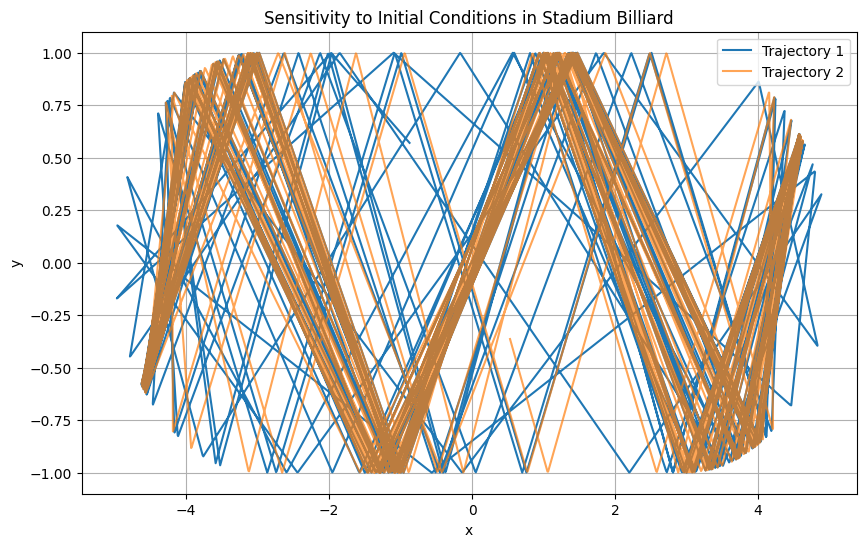

In [53]:
X1, Y1, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=40000)
X2, Y2, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0 + 1e-6, 0.0, 1, 1, dt=0.01, steps=40000)

plt.figure(figsize=(10,6))
plt.plot(X1, Y1, label='Trajectory 1')
plt.plot(X2, Y2, label='Trajectory 2', alpha=0.7)
plt.legend()
plt.title('Sensitivity to Initial Conditions in Stadium Billiard')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()
